## LDA model - Latent Dirichlet Allocation
This notebook will train an **LDA** model based on a collection of news articles from the Australian news. The articles corresponding to the corpus were obtained using BeautifulSoup library in an additional jupyter file in the folder news_scrapper ('scrapping_news.ipynb'). With this initial point, in this notebook we proceed to **pre-process** the data and transform it to **vectorized** form. After this step we will train the LDA model and finish the document with some conclusions about the results.

### Preprocessing the data
This task will focus on tokenizing, stop_words removal, lemmatization and computing bigrams.

In [7]:
import pandas as pd
import numpy as np

# Loading the dataset
news_df = pd.read_csv('../news_scrapper/aus_news.csv')
news = news_df['content'].tolist()
news_df.head()

,title,content
0,Summary of today's events,"And with that, we’ll be closing the blog for t..."
1,Queensland to remove hotel quarantine exemptions,Queensland premier Annastacia Palaszczuk has a...
2,Victoria reports 11 deaths and 439 new infecti...,With less than 48 hours until childcare attend...
3,Liberal senator says she has experienced issue...,The Victorian Liberal senator Sarah Henderson ...
4,Paul Keating says young people worse off than ...,"Earlier today, former prime minister Paul Keat..."


In [1]:
from nltk.corpus import stopwords
stopword_set = set(stopwords.words('english'))

#### Tokenization

In [8]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r"[A-Za-z]\w+(?:[-'?]\w+)?")
for idx in range(len(news)):
    news[idx] = news[idx].lower()
    news[idx] = tokenizer.tokenize(news[idx])
    
news[0][:10] # news is a list of articles which are a list of tokens (list of lists)

['and', 'with', 'that', 'we', 'll', 'be', 'closing', 'the', 'blog', 'for']

#### Remove numbers, Stop words and one-character words

In [9]:
# Remove numbers, but not words that contain numbers.
news = [[token for token in article if not token.isnumeric()] for article in news]

# Remove words that are only one character.
news = [[token for token in article if len(token) > 1] for article in news]

# Remove stopwords
news = [[token for token in article if token not in stopword_set] for article in news]

#### Lemmatization

In [10]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
news = [[lemmatizer.lemmatize(token) for token in article] for article in news]

In [12]:
news[0][:8] # news is a list of articles which are a list of tokens (list of lists)

['closing', 'blog', 'today', 'thanks', 'reading', 'amy', 'remeikis', 'running']

#### Bigrams
Bigrams and trigrams are added considering the minimum count they should have in documents and the parameter threshold is included, which is a score where higher value means less phrases. 

In [20]:
from gensim.models import Phrases
from gensim.corpora import Dictionary

# Add bigrams and trigrams to docs (only ones that appear 5 times or more, as is a small dataset).
bigram = Phrases(news, min_count=5, threshold=3) 
for idx in range(len(news)): 
    for token in bigram[news[idx]]: # for each token in tokens+bigrams per article in news
        if '_' in token: # Token is a bigram, add to document.            
            news[idx].append(token)

# Create a dictionary representation of the documents.
news_dict = Dictionary(news)

### Vectorized Representations of the news articles

In [21]:
# Remove rare and common tokens. Filter words that occur less than 5 documents, or more than 60% of the documents.
news_dict.filter_extremes(no_below=5, no_above=0.6)

# Bag-of-words representation of the documents.
corpus = [news_dict.doc2bow(content) for content in news]

In [22]:
print('Number of unique tokens: %d' % len(news_dict))
print('Number of news: %d' % len(corpus))

Number of unique tokens: 771
Number of news: 68


### Training LDA
For this section an important parameter to consider is the number of topics. It is not an easy task to come up with an optimal parameter, however, the approach to check for a good performance is running the model and validating the results to check whether they make sense and are specific enough.

`chunksize` determines number of documents processed at a time in the training. As long as it fits in memory, increasing it will speed up training. `passes` controls how often we train the model on the entire corpus ("epochs"). 

Here we use logging to validate that most of the documents have converged, which means the `passes` hyperparamater is fine. 

In [23]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [24]:
# Train LDA model.
from gensim.models import LdaModel

def train_LDA (n_topics, my_dict):
    # Set training parameters.
    NUM_TOPICS = n_topics
    chunksize = 100 # enough to process the 68 articles in one go
    passes = 10
    iterations = 100
    eval_every = None  

    # Make an index to word dictionary.
    temp = my_dict[0]  # "loading" the dictionary.
    id2word = my_dict.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=NUM_TOPICS,
        passes=passes,
        eval_every=eval_every
    )
    outputfile = f'model{NUM_TOPICS}.gensim'
    print("Saving model in " + outputfile)
    print("")
    model.save(outputfile)
    return model

In [115]:
np.random.seed(123)
model = train_LDA(7,news_dict) # train LDA model with 7 topics

2020-08-06 09:18:32,865 : INFO : using autotuned alpha, starting with [0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715]
2020-08-06 09:18:32,867 : INFO : using serial LDA version on this node
2020-08-06 09:18:32,869 : INFO : running online (multi-pass) LDA training, 7 topics, 10 passes over the supplied corpus of 68 documents, updating model once every 68 documents, evaluating perplexity every 0 documents, iterating 100x with a convergence threshold of 0.001000
2020-08-06 09:18:32,871 : INFO : PROGRESS: pass 0, at document #68/68
2020-08-06 09:18:33,020 : INFO : optimized alpha [0.14766884, 0.094065174, 0.10702388, 0.117090225, 0.09599061, 0.097138196, 0.21225592]
2020-08-06 09:18:33,022 : INFO : topic #1 (0.094): 0.012*"sport" + 0.010*"one" + 0.010*"football" + 0.009*"like" + 0.009*"thing" + 0.008*"two" + 0.008*"would" + 0.007*"show" + 0.006*"people" + 0.006*"year"
2020-08-06 09:18:33,023 : INFO : topic #4 (0.096): 0.016*"health" + 0.013*"found" + 0.0

2020-08-06 09:18:33,527 : INFO : topic #6 (0.124): 0.014*"year" + 0.012*"say" + 0.011*"people" + 0.010*"australia" + 0.009*"one" + 0.009*"time" + 0.008*"even" + 0.008*"world" + 0.007*"like" + 0.007*"would"
2020-08-06 09:18:33,528 : INFO : topic diff=0.208511, rho=0.377964
2020-08-06 09:18:33,531 : INFO : PROGRESS: pass 6, at document #68/68
2020-08-06 09:18:33,603 : INFO : optimized alpha [0.050043404, 0.04132782, 0.047551673, 0.044470146, 0.03738473, 0.04804279, 0.11681726]
2020-08-06 09:18:33,606 : INFO : topic #4 (0.037): 0.026*"health" + 0.024*"press_conference" + 0.019*"found" + 0.015*"report" + 0.014*"made" + 0.010*"review" + 0.009*"melbourne" + 0.009*"say" + 0.009*"fan" + 0.009*"woman"
2020-08-06 09:18:33,607 : INFO : topic #1 (0.041): 0.027*"sport" + 0.019*"minute" + 0.016*"add" + 0.015*"football" + 0.013*"two" + 0.012*"one" + 0.010*"would" + 0.009*"house" + 0.008*"man" + 0.008*"could"
2020-08-06 09:18:33,608 : INFO : topic #5 (0.048): 0.020*"community" + 0.015*"park" + 0.014*"

Saving model in model7.gensim



### LDA Results Analysis

#### Topic coherence

In [116]:
top_topics = model.top_topics(corpus) #, num_words=20)
NUM_TOPICS = 7
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -2.4052.
[([(0.014110154, 'year'),
   (0.01218112, 'say'),
   (0.011778783, 'people'),
   (0.009801376, 'australia'),
   (0.009358649, 'time'),
   (0.00865316, 'one'),
   (0.008048212, 'even'),
   (0.008033071, 'world'),
   (0.0077828397, 'like'),
   (0.007183029, 'show'),
   (0.0070145475, 'would'),
   (0.0070080627, 'thing'),
   (0.0063526887, 'good'),
   (0.006273866, 'new'),
   (0.0062694815, 'two'),
   (0.0061436184, 'also'),
   (0.006089604, 'want'),
   (0.005249405, 'get'),
   (0.005161024, 'make'),
   (0.0050446615, 'prime_minister')],
  -0.7503649031670567),
 ([(0.020597823, 'community'),
   (0.015006977, 'covid-19'),
   (0.01457717, 'lockdown'),
   (0.014529625, 'park'),
   (0.014276235, 'stage_four'),
   (0.013524731, 'case'),
   (0.013082066, 'people'),
   (0.012471775, 'last_week'),
   (0.011052084, 'australia'),
   (0.011017077, 'flight'),
   (0.010907366, 'work'),
   (0.0104216635, 'government'),
   (0.009703801, 'time'),
   (0.008181911, 'get'),

#### Visualization
After selecting 7 topics the graph below shows that most of them are separated from each other with just some overlapping between 1 and 2. Most of them seem to relate to the covid pandemic and the topics seem to identify the political content of the news with terms like prime_minister, daniel_andrew or federal_government and the different consequences of the pandemic like lockdown, stage_four, or border. After the visualization we will have a deeper look into the topic containing sport, minute, add, football among other tokens to have an idea of the articles that are referring to this terms.

In [117]:
# !pip3 install pyLDAvis
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model, corpus, news_dict, sort_topics=True)
pyLDAvis.display(lda_display)

/Users/david/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


#### Exploring the content for some of the main words
As described before, we will further explore the topic related to some specific terms which can be observed in the following graph from the above Intertopic Distance Map

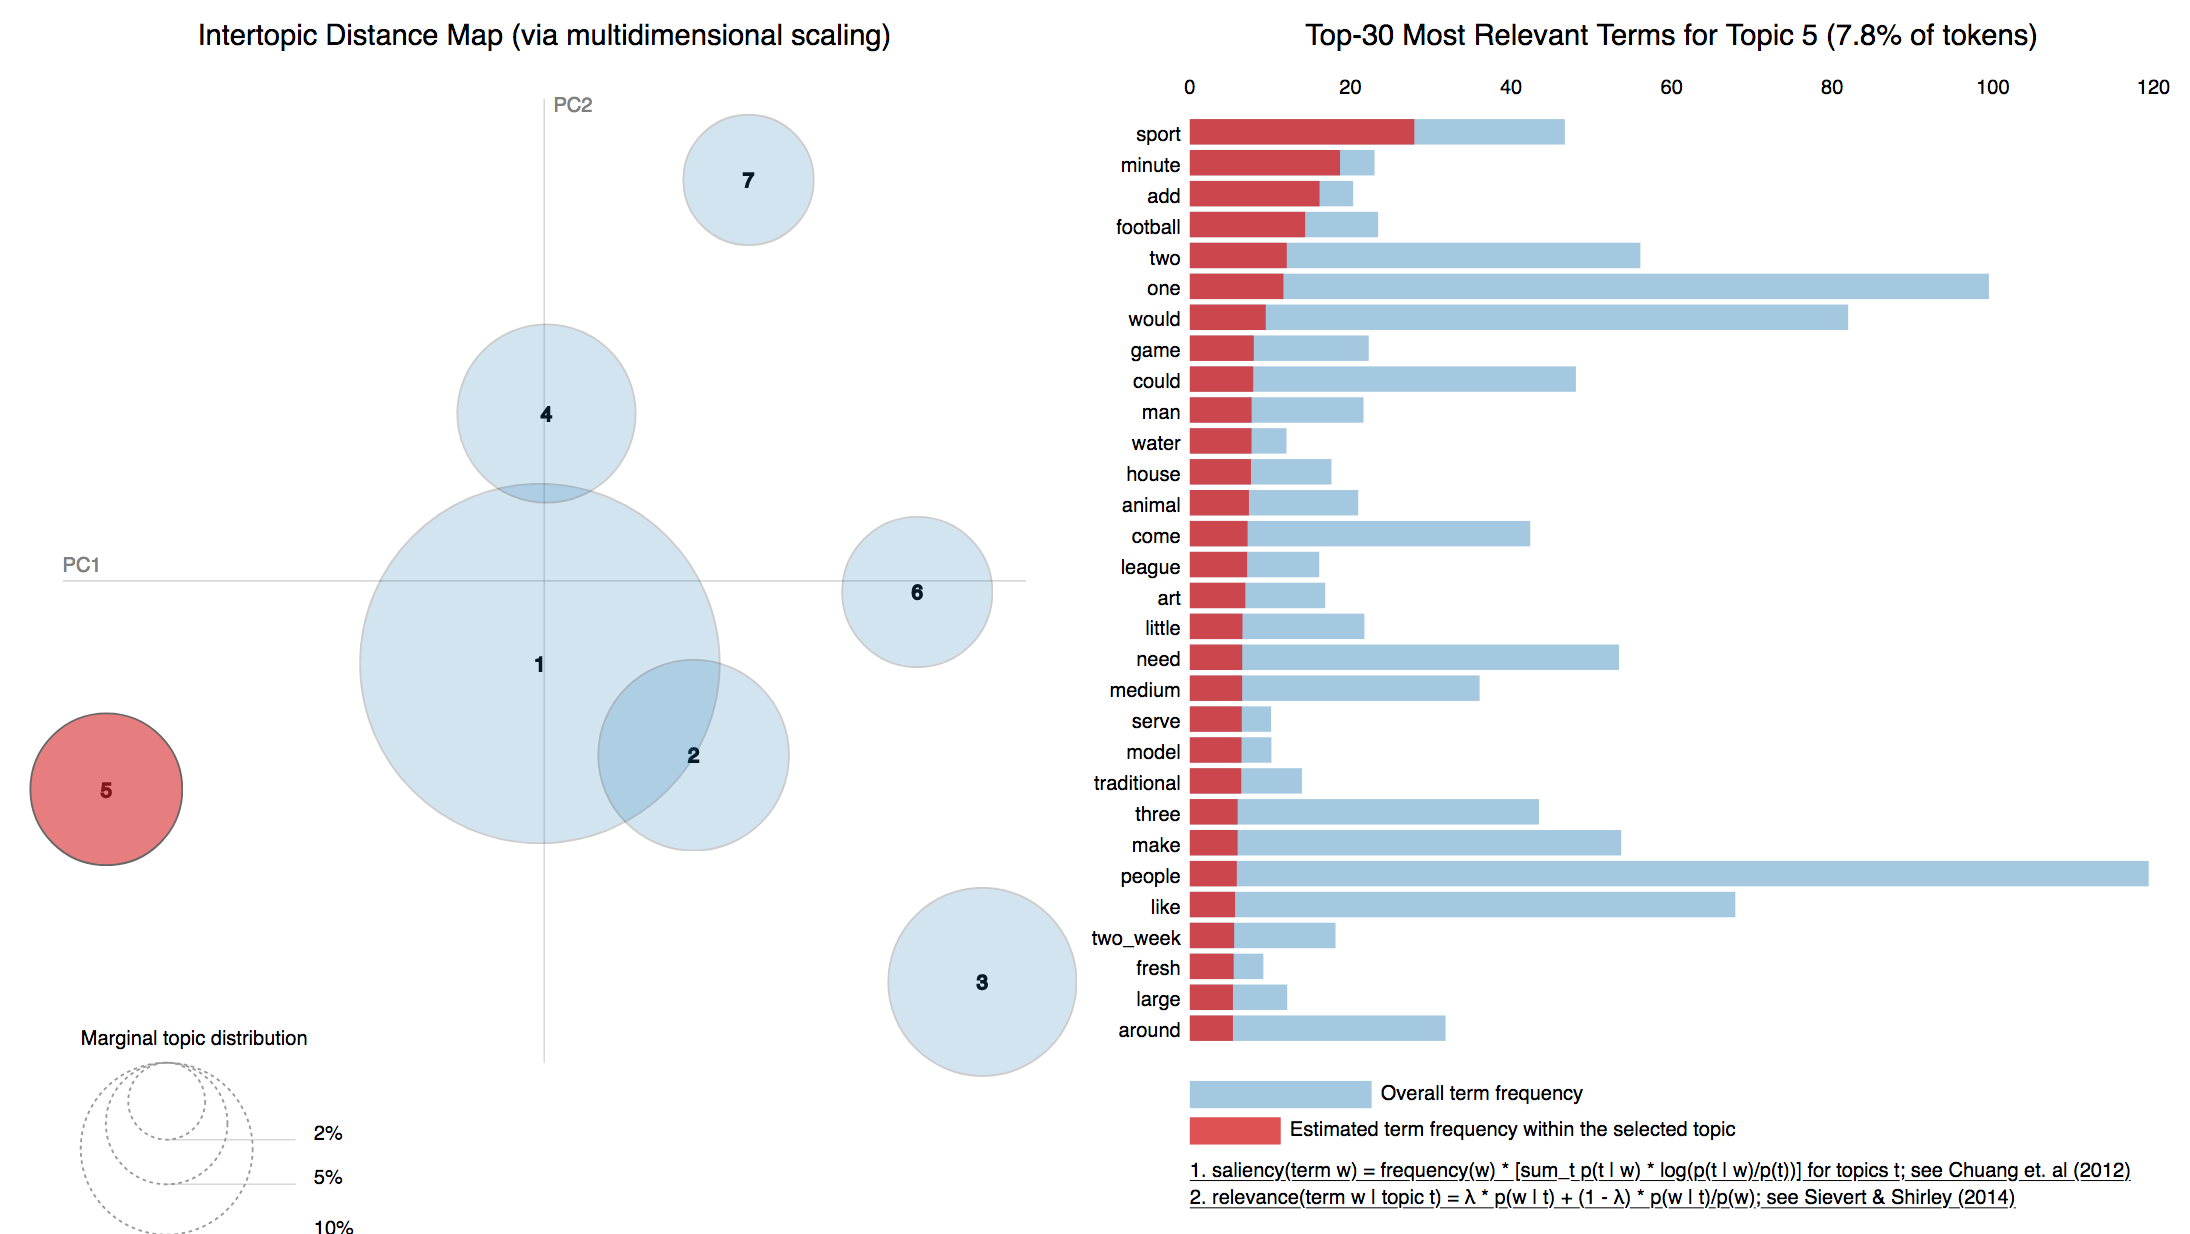

In [127]:
topic_num = 6 # topic to check for news articles

# top_topics has all topics with a tuple of tokens,coherence and tokens are a tuple of prob,token
chk_words = [tup[1] for tup in top_topics[topic_num][0][:3]] # get a list of top n words for topic_num
news_index = []
for i,article in enumerate(news):
    count=0
    for word in chk_words:
        if word in article:
            count+=1
    if len(chk_words)==count:
        news_index.append(i)
        
chk_words, news_index

(['sport', 'minute', 'add'], [47])

In [134]:
print('Article Title:',news_df.iloc[news_index[0]].title.strip(),'\n')
# Checking parts of the article containing key words
for word in chk_words: 
    word_idx = news_df.iloc[news_index[0]].content.lower().find(' '+str(word))
    if word_idx != -1:
        print(news_df.iloc[news_index[0]].content[word_idx-100:word_idx+100],'\n')

Article Title: Women’s sport faces broadcast barrier as small issues add up to significant problems 

conference declaring a state of disaster. Clearly, no one can be critical of the decision to leave a sporting event to provide a vital update on the biggest crisis facing Australia, and particularly V 

 

 that small decisions like this demonstrate the priorities of broadcasters and media outlets. It all adds up and can act as a barrier to broadening the audience. The Australian government has recognis 



The above results show some of the lines containing the key terms for topic 6 (5 in the Intertopic Distance Map) where it can be seen that although it refers to women's sport, it is still related to the crisis Australia is going through during the covid pandemic, which can explain why the distance between this topic and others is not as big as one would expect in case it was referring to sport topics exclusively.